In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import preprocess

In [111]:
data = pd.read_csv('data/caspecoTrainingData.csv')


In [112]:

sales, closed_days,_ = preprocess(data, fill_dates=True, norm_by="month")

# 2020-01-01. 0
# 2020-03-10  1
# 2020-03-23. 2
# 2020-07-02. 3
# 2020-11-03. 4
# 2020-12-22. 5
# 2021-03-01. 6
# 2021-07-15. 4
# 2021-09-29. 1
# 2021-12-23. 3
# 2022-02-09. 1
# 2022-03-29. 0
# restriction grades above, set dates after
"""
sales['Restriction'] = 0
sales['Restriction'] = np.where(sales['Date'] > '2020-03-10', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-03-23', 2, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-07-02', 3, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-11-03', 4, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-12-22', 5, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-03-01', 6, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-07-15', 4, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-09-29', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-12-23', 3, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2022-02-09', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2022-03-29', 0, sales['Restriction'])

"""

{0: array([620487.06151161]), 1: array([896135.53119759]), 2: array([5468590.99734427])}
Company 0 closed on month/day 1/1, 4 times
Company 0 closed on month/day 12/24, 3 times
Company 0 closed on week/weekday 4/25, 3 times
Company 0 closed on week/weekday 5/25, 3 times
Company 0 closed on week/weekday 6/15, 3 times
Company 0 closed on week/weekday 6/25, 3 times
Company 0 closed on week/weekday 6/52, 3 times
Company 1 closed on month/day 12/24, 3 times
Company 1 closed on month/day 12/31, 3 times
Company 1 closed on week/weekday 4/25, 3 times


"\nsales['Restriction'] = 0\nsales['Restriction'] = np.where(sales['Date'] > '2020-03-10', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-03-23', 2, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-07-02', 3, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-11-03', 4, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-12-22', 5, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-03-01', 6, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-07-15', 4, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-09-29', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-12-23', 3, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2022-02-09', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2022-03-29', 0, sales['Restriction'])\n\n"

In [113]:
for company in sales['Company'].unique():
    print(len(sales[(sales['Company'] == company) & (sales['Sales'] == 0)]))

110
105
0


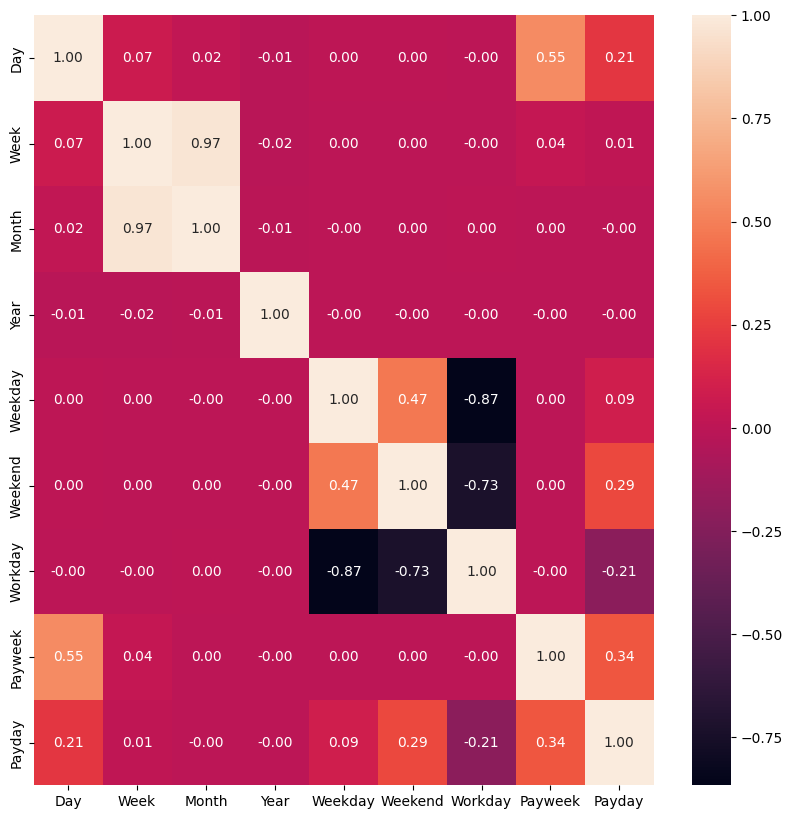

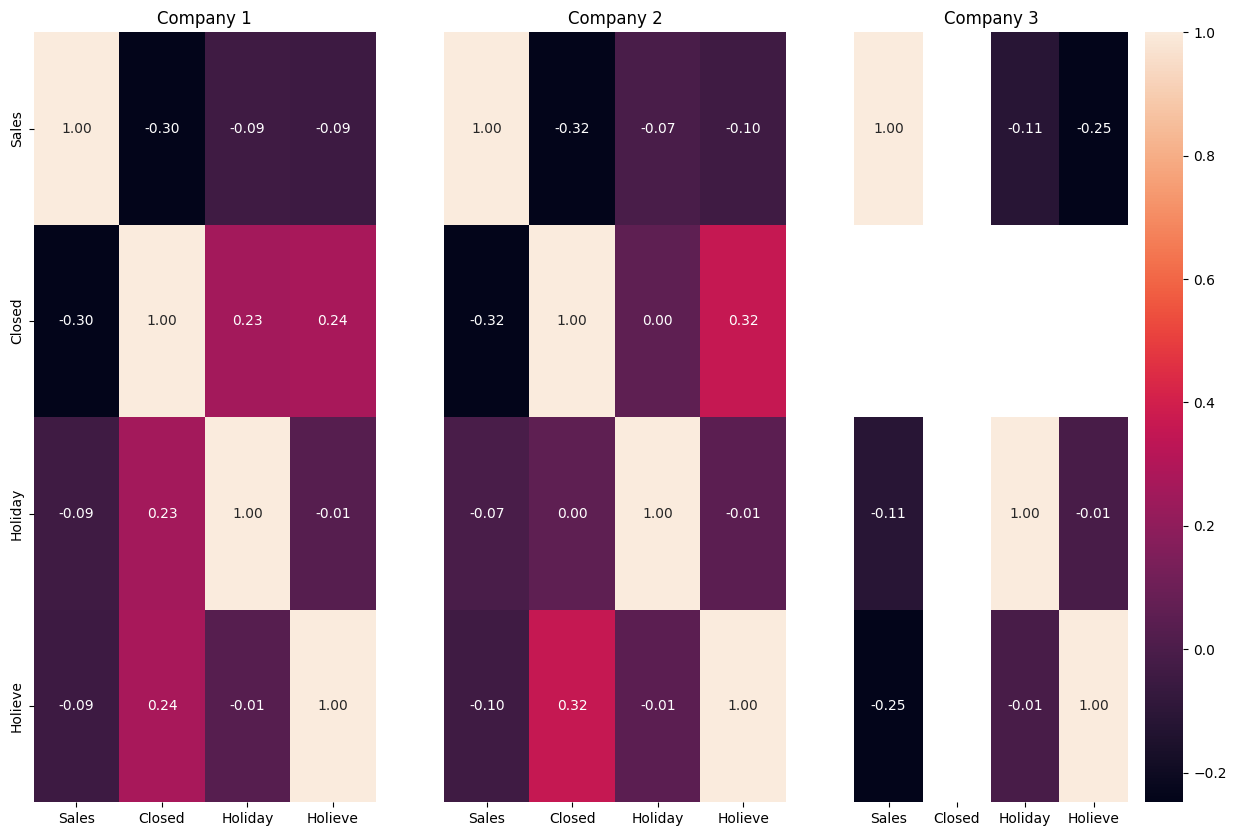

In [114]:
# plot correlation of features
corr = sales.drop(columns=['Company','Sales','Closed','Date','Holiday','Holieve']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
for company in [0,1,2]:
    corr = sales[sales['Company'] == company][['Sales','Closed','Holiday','Holieve']].corr()
    cbar = True if company == 2 else False
    yticklabels = True if company == 0 else False
    sns.heatmap(corr, annot=True, fmt='.2f', ax=axs[company], cbar=cbar, yticklabels=yticklabels)
    axs[company].set_title(f'Company {company+1}')


In [115]:
for company in closed_days:
    print("Closed month/day")
    for month, days in closed_days[company]['md']:
        print(month, days)
    print("Closed week/weekday range")
    for weekday, week in closed_days[company]['wd']:
        print(week, weekday)


Closed month/day


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [116]:
sales['Season'] = sales['Date'].dt.quarter
X = sales.drop(['Date','Sales','Year', 'Workday', 'Payweek', 'Month'], axis=1)
X = pd.get_dummies(X, columns=['Weekday', 'Season', 'Week', 'Day'])
y = sales['Sales']
X_split = [X[X['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]]
y_split = [sales[sales['Company'] == i]['Sales'] for i in [0,1,2]]

[-0.07381025 -0.05359252 -0.04619739 -0.04562423 -0.05436579]


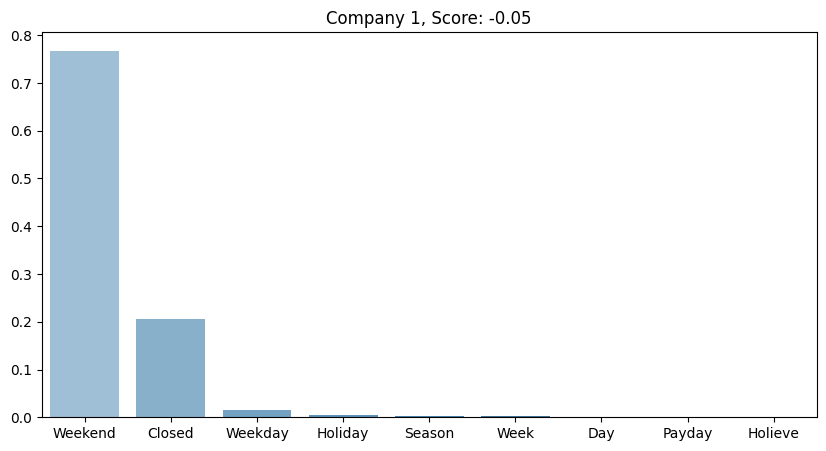

[-0.08600131 -0.05757997 -0.07845412 -0.05391045 -0.06620443]


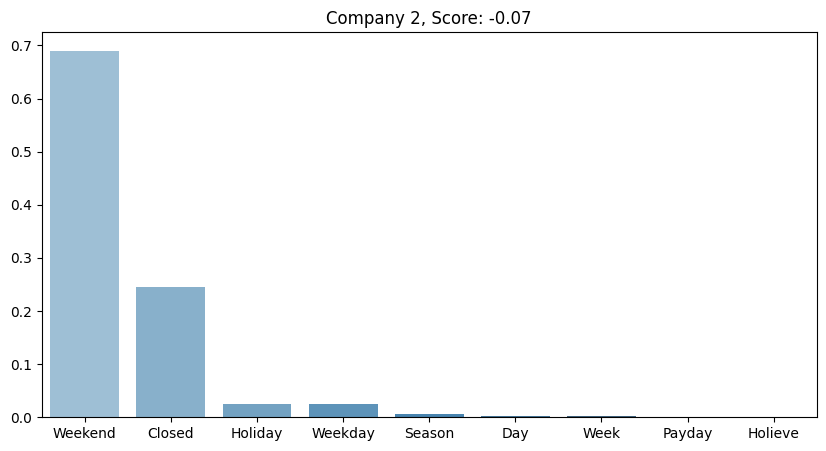

[-0.02547058 -0.0317392  -0.03572539 -0.0400635  -0.02415251]


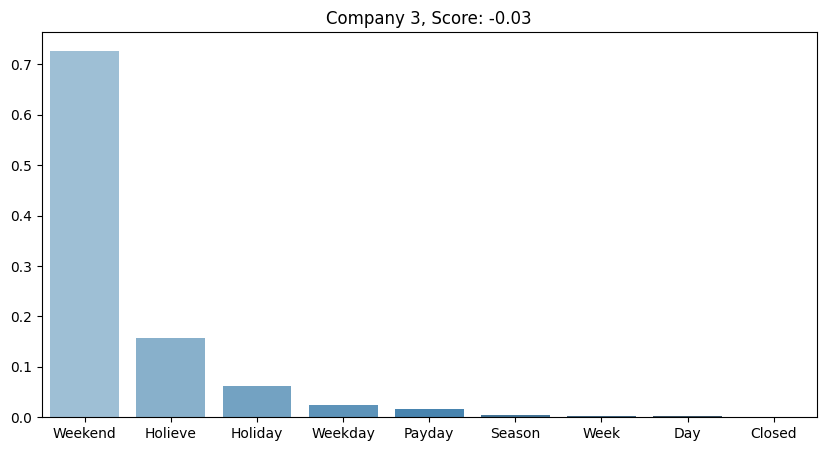

In [150]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

RSMD = make_scorer(lambda y, y_pred: -sqrt(mean_squared_error(y, y_pred)))

estimators = {}
features = {}
# add params for random forest

for X_i, y_i, company in zip(X_split, y_split, [0, 1, 2]):
    cv = cross_validate(RandomForestRegressor(**hgs.best_params_), X_i, y_i,
                        scoring=RSMD, return_train_score=True, return_estimator=True)
    # take mean of feature importances from all 5 models
    estimators[company] = cv['estimator'][np.argmax(cv['test_score'])]

    
    print(cv['test_score'])
    # plot 20 most important features
    feature_importances = np.mean(
        [est.feature_importances_ for est in cv['estimator']], axis=0)

    feature_importances = pd.Series(feature_importances, index=X_i.columns)
    # group by feature name that are the same before the underscore if there is an underscore
    feature_importances = feature_importances.groupby(
        lambda x: x.split('_')[0]).mean().sort_values(ascending=False)
    # scale sum to 1
    feature_importances = feature_importances / feature_importances.sum()
    features[company] = feature_importances
    # plot importances with sns
    plt.figure(figsize=(10, 5))
    plt.title(f'Company {company+1}, Score: {cv["test_score"].mean():.2f}')
    sns.barplot(x=feature_importances.index, y=feature_importances.values, palette='Blues_d')
    plt.show()
    

In [149]:
X_comp = pd.get_dummies(X, columns=['Company'])

# import halving grid search cv
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# define params for random forest
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# define halving grid search cv
hgs = HalvingGridSearchCV(RandomForestRegressor(), params, cv=5, scoring=RSMD, factor=2, min_resources='exhaust', n_jobs=-1)

# get best params
hgs.fit(X_comp, y)
print(hgs.best_params_)

{'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [151]:
cv = cross_validate(RandomForestRegressor(**hgs.best_params_), X_comp, y, cv=5,
                    scoring=RSMD, return_train_score=True, return_estimator=True)


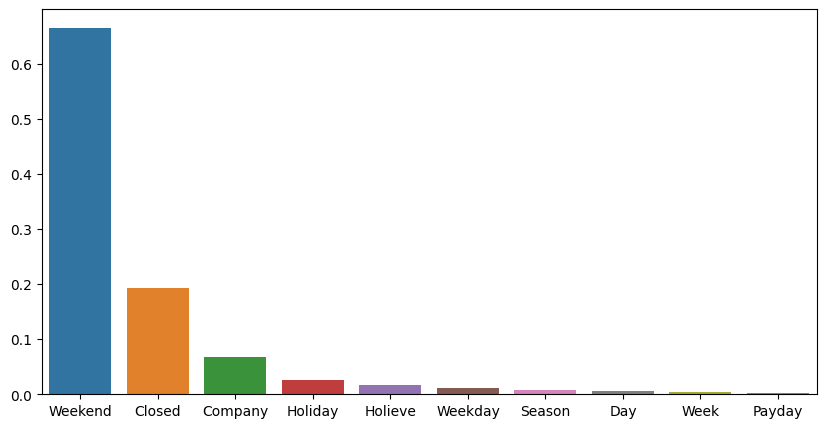

In [119]:
feature_importances = np.mean(
    [est.feature_importances_ for est in cv['estimator']], axis=0)

feature_importances = pd.Series(feature_importances, index=X_comp.columns)
# group by feature name that are the same before the underscore if there is an underscore
feature_importances = feature_importances.groupby(
    lambda x: x.split('_')[0]).mean().sort_values(ascending=False)
# rescale so that the sum is 1
feature_importances = feature_importances / feature_importances.sum()
features[3] = feature_importances
#plot importances with sns
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances.index, y=feature_importances.values)
plt.show()


/tmp/ipykernel_5464/4105058947.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[company//2, company%2].set_xticklabels(axs[company//2, company%2].get_xticklabels())
/tmp/ipykernel_5464/4105058947.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[company//2, company%2].set_xticklabels(axs[company//2, company%2].get_xticklabels())
/tmp/ipykernel_5464/4105058947.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[company//2, company%2].set_xticklabels(axs[company//2, company%2].get_xticklabels())
/tmp/ipykernel_5464/4105058947.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


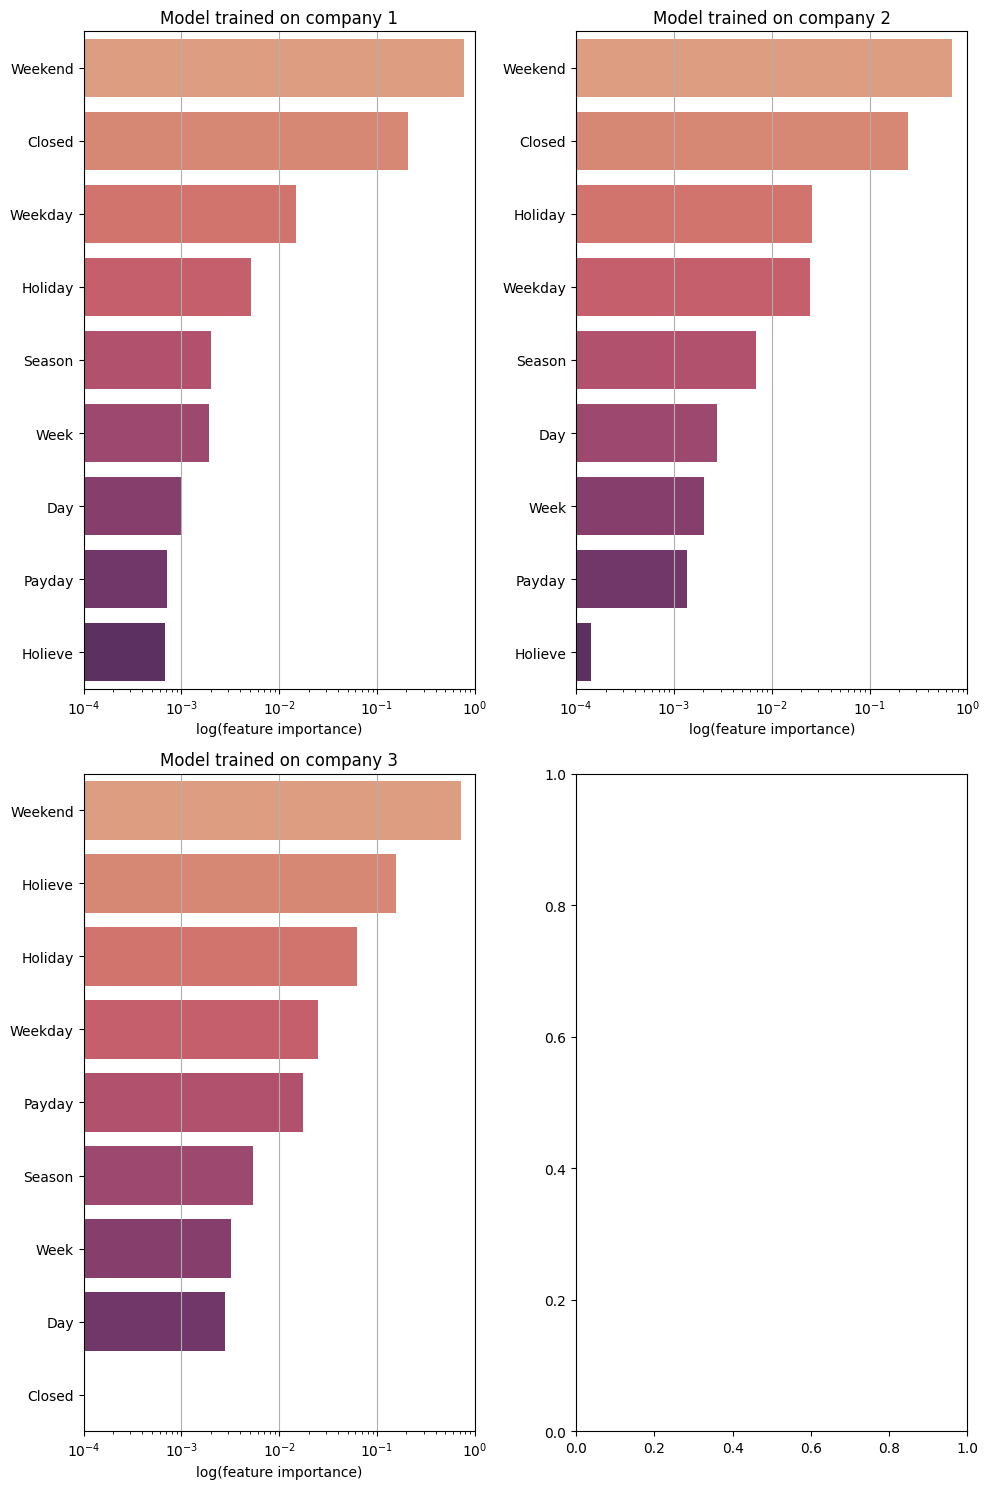

In [152]:
fig, axs = plt.subplots(2, 2, figsize=(10, 15))
for company, feature_importances in features.items():
    sns.barplot(y=feature_importances.index, x=feature_importances.values, ax=axs[company//2, company%2], palette='flare')
    if company < 3:
        axs[company//2, company%2].set_title(f'Model trained on company {company+1}')
    else:
        axs[company//2, company%2].set_title('Model trained on all companies')
    axs[company//2, company%2].set_xticklabels(axs[company//2, company%2].get_xticklabels())
    # use log scale for x axis
    axs[company//2, company%2].set_xscale('log')
    # set lim to 1e-3 to 1e0
    # set x label to "log of feature importance"
    axs[company//2, company%2].set_xlabel('log(feature importance)')
    axs[company//2, company%2].set_xlim(1e-4, 1e0)
    axs[company//2, company%2].xaxis.grid(True)
fig.tight_layout()
fig.show()

In [153]:
# data sales from 09
actual_data, _ = preprocess(data, fill_dates=True)
validation = actual_data[actual_data['Date'] >= '2022-11-01']


Company 0 closed on month/day 1/1, 4 times
Company 0 closed on month/day 12/24, 3 times
Company 0 closed on week/weekday 4/25, 3 times
Company 0 closed on week/weekday 5/25, 3 times
Company 0 closed on week/weekday 6/15, 3 times
Company 0 closed on week/weekday 6/25, 3 times
Company 0 closed on week/weekday 6/52, 3 times
Company 1 closed on month/day 12/24, 3 times
Company 1 closed on month/day 12/31, 3 times
Company 1 closed on week/weekday 4/25, 3 times


In [154]:
validation_sales = validation['Sales']
validation['Season'] = validation['Date'].dt.quarter
X_valid = validation.drop(
    ['Date', 'Sales', 'Year', 'Month', 'Workday', 'Payweek'], axis=1)
X_valid = pd.get_dummies(X_valid, columns=['Weekday', 'Week', 'Season', 'Day'])
# fill with missing columns form X
for col in X.columns:
  if col not in X_valid.columns:
    X_valid[col] = 0
X_valid_dict = {i: X_valid[X_valid['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]}
X_valid_dict['all'] = pd.get_dummies(X_valid, columns=['Company'])

predicitions = validation[['Date', 'Company']]
predicitions['Pred_company'] = 0
for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(X_valid_dict[company])
  predicitions[predicitions['Company'] == company] = company_df

predicitions['Pred_all'] = cv['estimator'][np.argmax(cv['test_score'])].predict(X_valid_dict['all'])

/tmp/ipykernel_5464/3776092897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Season'] = validation['Date'].dt.quarter
/tmp/ipykernel_5464/3776092897.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicitions['Pred_company'] = 0
/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fi

In [155]:
predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)

for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_company'].sum()
  company_df.loc[:, 'Pred_all'] = company_df['Pred_all'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_all'].sum()
  company_df.loc[:, 'Pred_mean'] = company_df['Pred_mean'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_mean'].sum()
  predicitions[predicitions['Company'] == company] = company_df

/tmp/ipykernel_5464/2693500436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)
/tmp/ipykernel_5464/2693500436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_company'].sum()
/tmp/ipykernel_5464/2693500436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

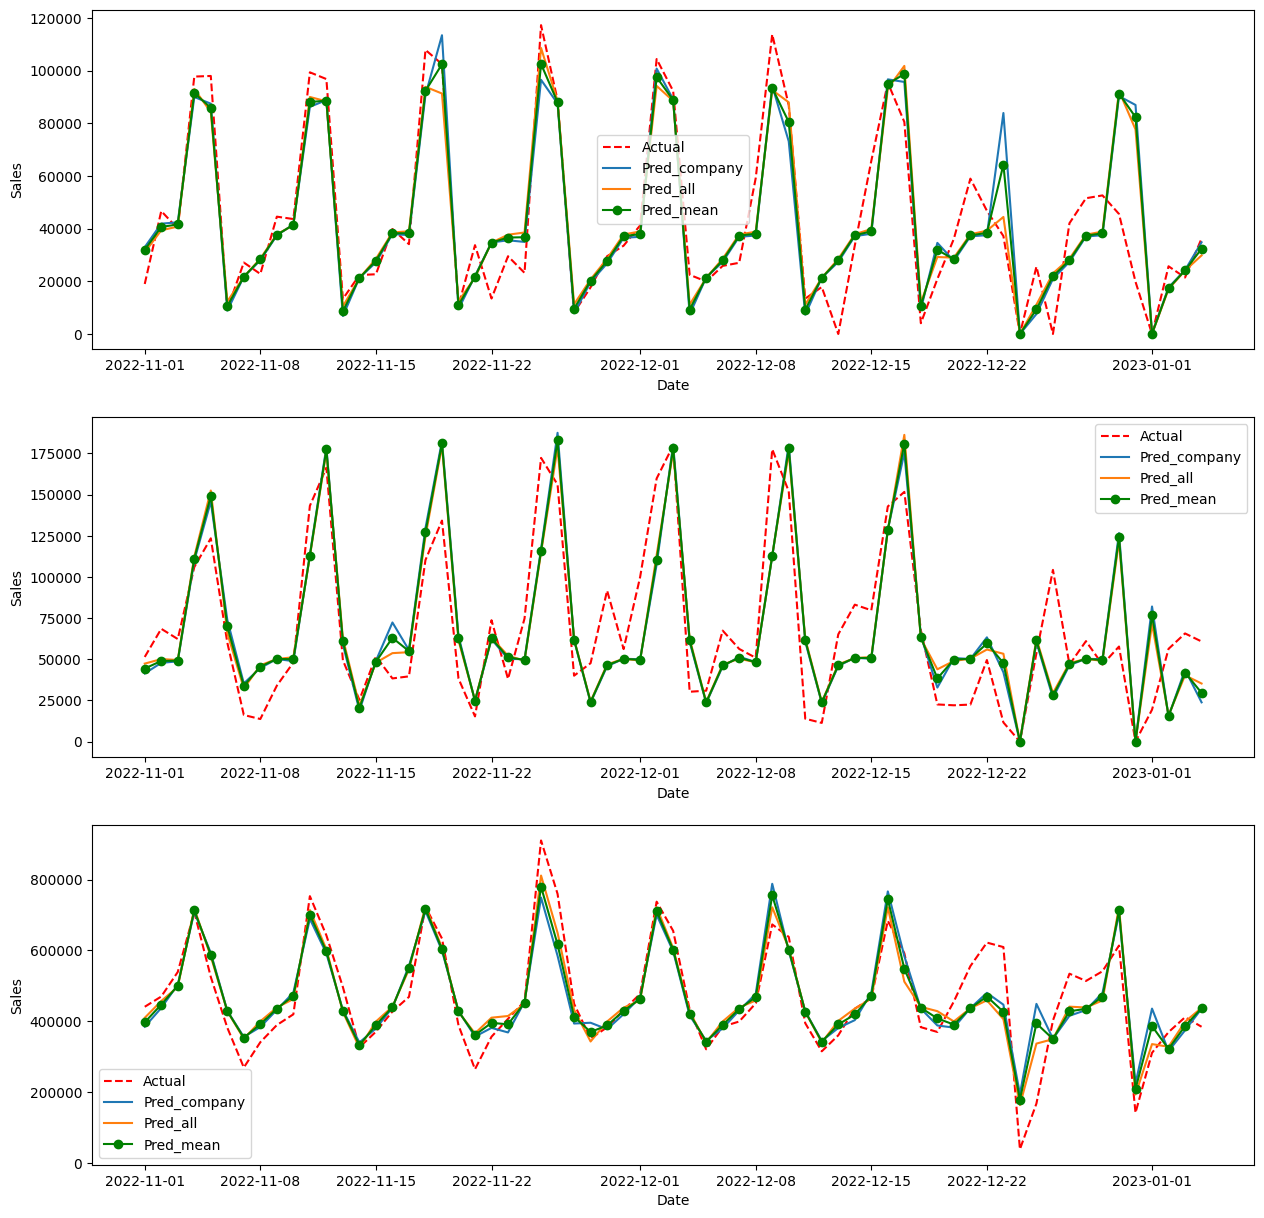

In [156]:
# plot all predictions per company
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for company in [0,1,2]:
  x = predicitions[predicitions['Company'] == company]['Date']
  actual = validation_sales[validation['Company'] == company]
  pred_company = predicitions[predicitions['Company'] == company]['Pred_company']
  pred_all = predicitions[predicitions['Company'] == company]['Pred_all']
  pred_mean = predicitions[predicitions['Company'] == company]['Pred_mean']
  ax[company].plot(x, actual, 'r--',  label='Actual')
  ax[company].plot(x, pred_company, label='Pred_company')
  ax[company].plot(x, pred_all, label='Pred_all')
  ax[company].plot(x, pred_mean, 'g-o', label='Pred_mean')
  ax[company].legend()
  ax[company].set_xlabel('Date')
  ax[company].set_ylabel('Sales')


In [164]:
actual_data, _ = preprocess(data, fill_dates=True)


Company 0 closed on month/day 1/1, 4 times
Company 0 closed on month/day 12/24, 3 times
Company 0 closed on week/weekday 4/25, 3 times
Company 0 closed on week/weekday 5/25, 3 times
Company 0 closed on week/weekday 6/15, 3 times
Company 0 closed on week/weekday 6/25, 3 times
Company 0 closed on week/weekday 6/52, 3 times
Company 1 closed on month/day 12/24, 3 times
Company 1 closed on month/day 12/31, 3 times
Company 1 closed on week/weekday 4/25, 3 times


/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/tmp/ipykernel_5464/2455615268.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(to_predict_dict[company])
/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(

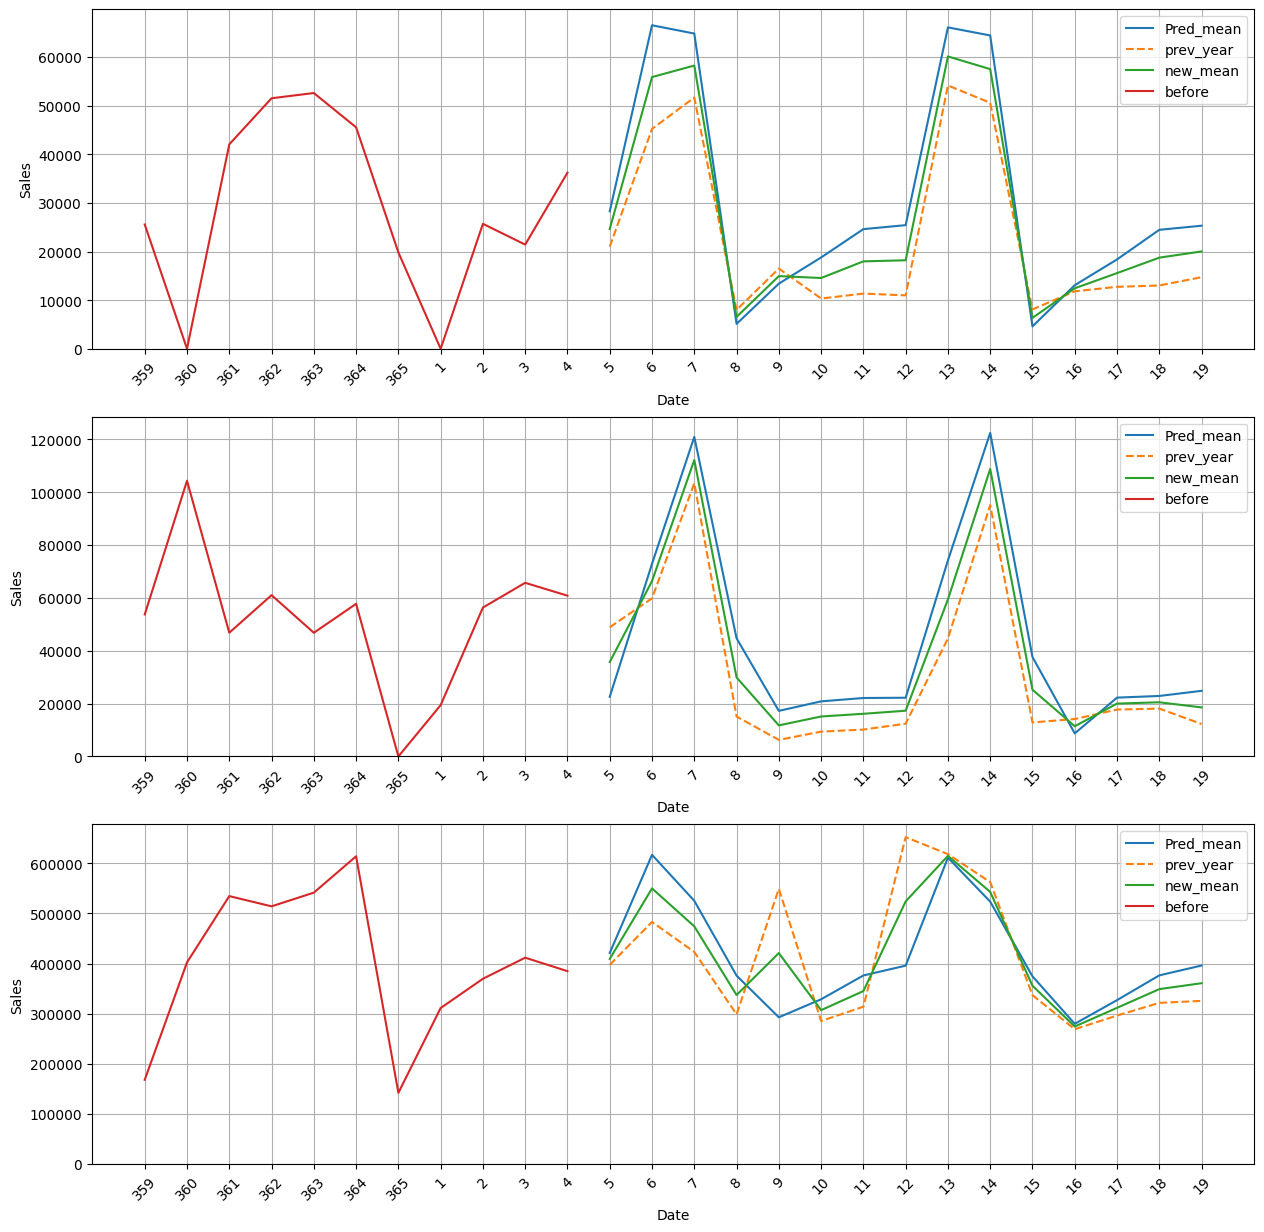

In [167]:
new_dates = pd.date_range("2023-01-05", "2023-01-19")
to_predict = pd.DataFrame({'Date': new_dates.repeat(3), 'Company': np.tile([0,1,2], len(new_dates)), 'Sales': 0})
to_predict.head()
to_predict, _ = preprocess(to_predict, fill_dates=False)
to_predict['Season'] = to_predict['Date'].dt.quarter
#X = sales.drop(['Date','Sales','Year', 'Workday', 'Payweek', 'Day', 'Month'], axis=1)
#X = pd.get_dummies(X, columns=['Weekday', 'Season', 'Week'])
to_predict = to_predict.drop(
    ['Date', 'Sales', 'Year', 'Workday', 'Payweek', 'Day', 'Month'], axis=1)
to_predict = pd.get_dummies(to_predict, columns=['Weekday', 'Season', 'Week'])
# add columns missing from X
for col in X.columns:
  if col not in to_predict.columns:
    to_predict[col] = 0

to_predict_dict = {i: to_predict[to_predict['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]}
to_predict_dict['all'] = pd.get_dummies(to_predict, columns=['Company'])

predicitions = pd.DataFrame({'Date': new_dates.repeat(3), 'Company': np.tile([0, 1, 2], len(new_dates))})
predicitions['Pred_company'] = 0
for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(to_predict_dict[company])
  predicitions[predicitions['Company'] == company] = company_df

predicitions['Pred_all'] = cv['estimator'][np.argmin(cv['test_score'])].predict(to_predict_dict['all'])

predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)

for company in [0,1,2]:
  scale = validation_sales[validation['Company'] == company][-15:].mean()
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * scale / company_df['Pred_company'].mean()
  company_df.loc[:, 'Pred_all'] = company_df['Pred_all'] * scale / company_df['Pred_all'].mean()
  company_df.loc[:, 'Pred_mean'] = company_df['Pred_mean'] * scale / company_df['Pred_mean'].mean()
  predicitions[predicitions['Company'] == company] = company_df

# plot all predictions per company
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
predicitions['New_mean'] = 0
for company in [0,1,2]:
  x = pd.date_range("2022-12-25", "2023-01-19")
  pred_company = predicitions[predicitions['Company'] == company]['Pred_company']
  pred_all = predicitions[predicitions['Company'] == company]['Pred_all']
  pred_mean = predicitions[predicitions['Company'] == company]['Pred_mean']
  prev_year = actual_data[(actual_data['Company'] == company) & (
      actual_data['Date'] >= '2022-01-06') & (actual_data['Date'] <= '2022-01-20')]['Sales']
  # pad start for pred_company, pred_all, pred_mean and prev_year with zeros to match length of x

  before = actual_data[(actual_data['Company'] == company) & (
      actual_data['Date'] <= '2023-01-04') & (actual_data['Date'] >= '2022-12-25')]['Sales']
  # calculate mean between dataframe pred_mean and dataframe prev_year
  new_mean = (prev_year.to_numpy() + pred_mean.to_numpy()) / 2
  predicitions.loc[predicitions['Company'] == company, 'New_mean'] = new_mean
  # set ax xticks to x
  ax[company].set_xticks(x)
  ax[company].set_xticklabels(x.day_of_year, rotation=45)
  #ax[company].plot(x, pred_company, label='Pred_company')
  #ax[company].plot(x, pred_all, label='Pred_all')
  ax[company].plot(x[11:], pred_mean, label='Pred_mean')
  ax[company].plot(x[11:], prev_year, '--', label='prev_year')
  ax[company].plot(x[11:], new_mean, label='new_mean')
  ax[company].plot(x[:11], before, label='before')
  ax[company].grid()
  ax[company].legend()
  ax[company].set_xlabel('Date')
  ax[company].set_ylabel('Sales')
  ax[company].set_ylim(0)

In [171]:
# create an output dataframe with columns ID and Sales, where prediction['Date', 'Company'] is ID as YYYY-MM-DD_company and Sales is the prediction['Pred_mean']
output = pd.DataFrame({'ID': predicitions['Date'].astype(
    str) + '_' + predicitions['Company'].astype(str), 'Sales': predicitions['Pred_mean']})

output.to_csv('submission2.csv', index=False)
output.head()

,ID,Sales
0,2023-01-05_0,28277.738109
1,2023-01-05_1,22570.355996
2,2023-01-05_2,420995.050534
3,2023-01-06_0,66535.357414
4,2023-01-06_1,72879.067129


In [172]:
sub1 = pd.read_csv('submission.csv')
sub2 = pd.read_csv('submission2.csv')

# create a new df which has the difference between the two submissions
diff = pd.DataFrame({'ID': sub1['ID'], 'Sales': sub1['Sales'] - sub2['Sales']})
diff.head()

,ID,Sales
0,2023-01-05_0,-105.071292
1,2023-01-05_1,14596.572311
2,2023-01-05_2,26476.337023
3,2023-01-06_0,4351.136818
4,2023-01-06_1,5259.698822
